# Análise de dados do IBGE para a cidade de Manaus-AM

## Resumo

Neste notebook, iremos explorar dados do Censo de 2010 do IBGE utilizando a linguagem Python e as bibliotecas Folium e GeoPandas.

In [87]:
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import contextily
import folium
import matplotlib.pyplot as plt
import seaborn as sns

import os
from urllib.request import urlretrieve
import zipfile

Definindo os formato dos graficos

In [ ]:
sns.set(font_scale=1.4)
sns.set_style({'font.family': 'serif',
               'fontname': 'Times New Roman'})

## 1) Fontes de dados

### 1.1) Setores censitários

* Fonte: [Instituto Brasileiro de Geografia e Estatística (IBGE)](https://www.ibge.gov.br/geociencias/organizacao-do-territorio/malhas-territoriais/26565-malhas-de-setores-censitarios-divisoes-intramunicipais.html?=&t=downloads)

Criando uma pasta no diretorio

In [ ]:
if not os.path.exists('/kaggle/working/mapas'):
    os.makedirs('/kaggle/working/mapas')

Carregando os Dados

In [ ]:
url_setores_censitarios = 'https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_de_setores_censitarios__divisoes_intramunicipais/censo_2010/setores_censitarios_shp/am/am_setores_censitarios.zip'

In [ ]:
%%time

urlretrieve(url_setores_censitarios, '/kaggle/working/mapas/am_setores_censitarios.zip')

In [ ]:
with zipfile.ZipFile('/kaggle/working/mapas/am_setores_censitarios.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/mapas/')

Removendo o arquivo zip

In [ ]:
os.remove('/kaggle/working/mapas/am_setores_censitarios.zip')

Lendo o arquivo com o Geo Pandas

In [ ]:
am_setores_gdf = gpd.read_file('/kaggle/working/mapas/13SEE250GC_SIR.shp')

In [ ]:
am_setores_gdf.shape

In [ ]:
am_setores_gdf.head()

In [ ]:
am_setores_gdf.iloc[0].geometry

verificando o sistema de cordenadas

In [ ]:
am_setores_gdf.crs.to_string()

In [ ]:
am_setores_gdf = am_setores_gdf.to_crs(crs='EPSG:3857')

In [ ]:
am_setores_gdf.crs.to_string()

In [ ]:
ax = am_setores_gdf.plot(figsize=(15, 10), edgecolor='black', facecolor='none')
contextily.add_basemap(ax)
ax.set_axis_off()
plt.show()

Filtrando pelos municipios

In [ ]:
mao_setores_gdf = am_setores_gdf[am_setores_gdf['NM_MUNICIP'] == 'MANAUS']

In [ ]:
mao_setores_gdf.shape

In [ ]:
ax = mao_setores_gdf.plot(figsize=(15, 10), edgecolor='black', facecolor='none')
contextily.add_basemap(ax)
ax.set_axis_off()
plt.show()

Categrizando por Tipo

In [ ]:
ax = mao_setores_gdf.plot(figsize=(15, 10), edgecolor='black', column='TIPO', legend=True)
contextily.add_basemap(ax)
ax.set_axis_off()
plt.show()

Filtrando os dados urbanos

In [ ]:
mao_setores_urb_gdf = mao_setores_gdf[mao_setores_gdf['TIPO'] == 'URBANO']

In [ ]:
mao_setores_urb_gdf.shape

In [ ]:
ax = mao_setores_urb_gdf.plot(figsize=(15, 10), edgecolor='black', facecolor='none')
contextily.add_basemap(ax)
ax.set_axis_off()
plt.show()

In [ ]:
mao_setores_urb_gdf.head()

In [ ]:
mao_setores_urb_gdf['NM_BAIRRO'].unique()

In [ ]:
plt.figure(figsize=(50,8))

ax = sns.countplot(x='NM_BAIRRO', 
                   data=mao_setores_urb_gdf, 
                   order=mao_setores_urb_gdf['NM_BAIRRO'].value_counts().index)

labels = [item.get_text().replace(' ', '\n') for item in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation = 90)

ax.set_xlabel('Bairros de Manaus (AM)')
ax.set_ylabel('Qtd. de setores censitários')

plt.show()

In [ ]:
ax = mao_setores_urb_gdf.plot(figsize=(50, 30), edgecolor='black', column='NM_BAIRRO', legend=True)
contextily.add_basemap(ax)
ax.set_axis_off()
plt.show()

Salvando o arquivo no driver

In [ ]:
mao_setores_urb_gdf.to_file('/kaggle/working/mapas/mao_setores_urb.json', driver='GeoJSON')

### 1.2) Censo de 2010

* Fonte: [Instituto Brasileiro de Geografia e Estatística (IBGE)](https://www.ibge.gov.br/geociencias/downloads-geociencias.html)

In [ ]:
if not os.path.exists('/kaggle/working/censo2010'):
    os.makedirs('/kaggle/working/censo2010')

In [ ]:
url_censo_2010_am = 'https://ftp.ibge.gov.br/Censos/Censo_Demografico_2010/Resultados_do_Universo/Agregados_por_Setores_Censitarios/AM_20171016.zip'

In [ ]:
%%time

urlretrieve(url_censo_2010_am, '/kaggle/working/censo2010/AM_20171016.zip')

In [ ]:
with zipfile.ZipFile('/kaggle/working/censo2010/AM_20171016.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/censo2010/')

In [ ]:
os.remove('/kaggle/working/censo2010/AM_20171016.zip')

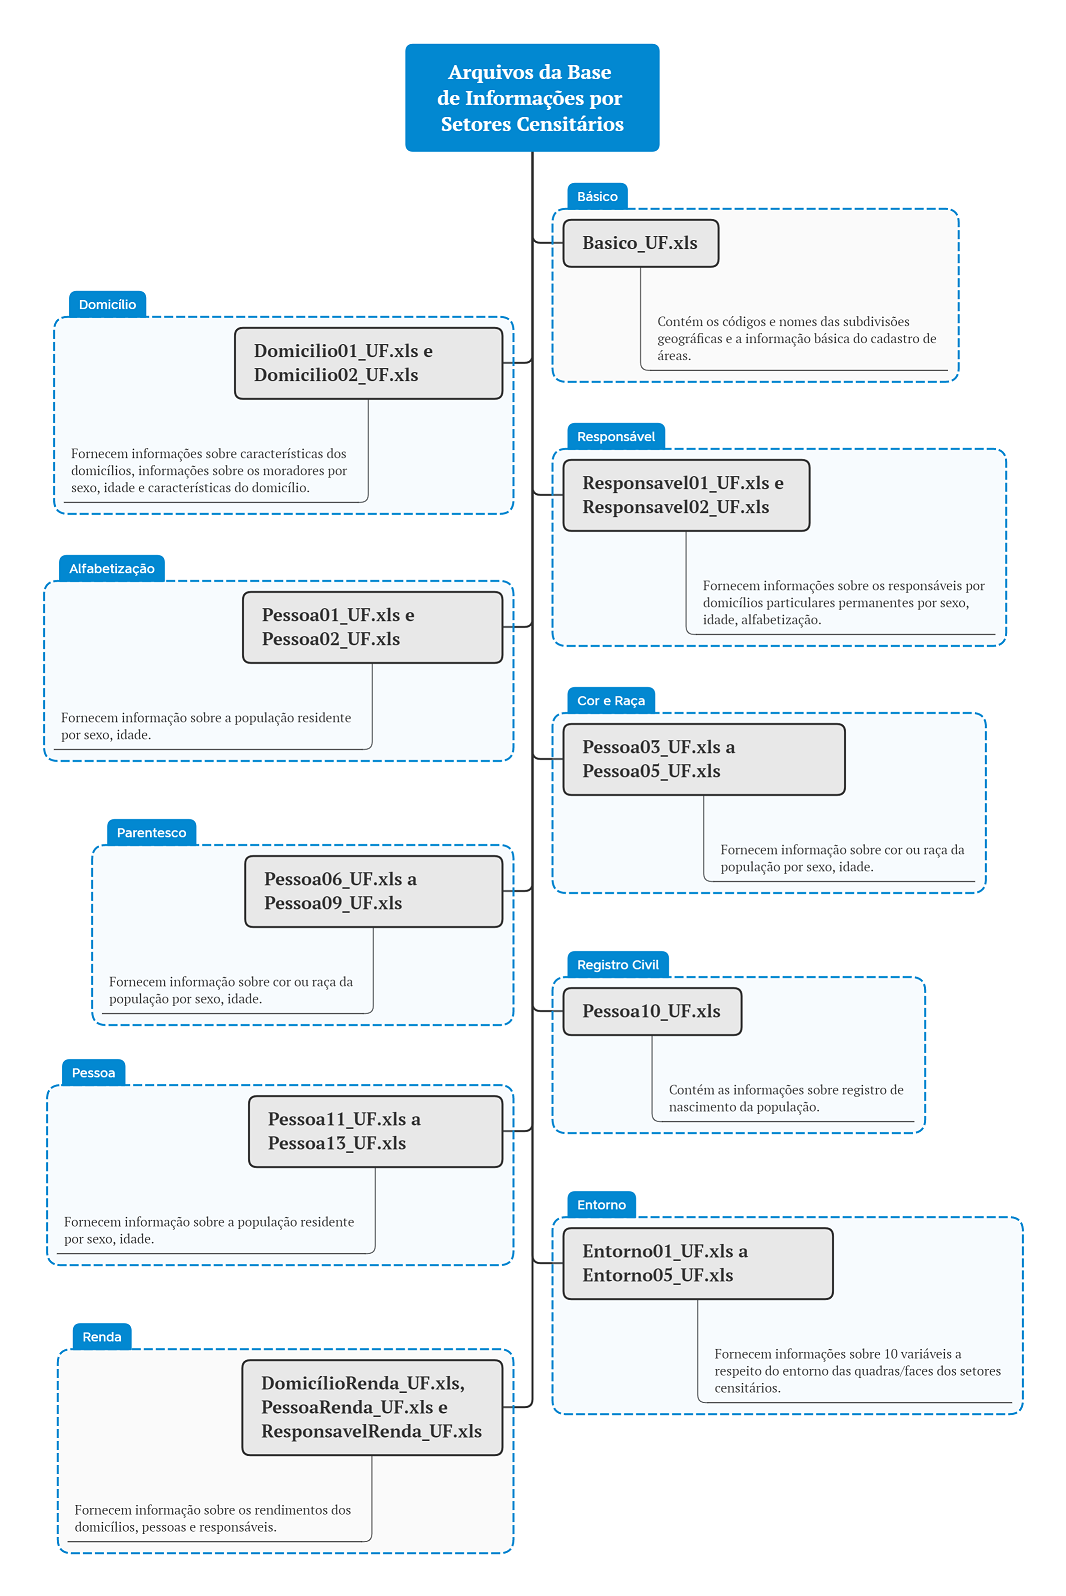

In [ ]:
am_censo_entorno01_df = pd.read_csv('/kaggle/working/censo2010/AM/Base informaçoes setores2010 universo AM/CSV/Entorno01_AM.csv', sep=';')

In [ ]:
am_censo_entorno01_df.shape

In [ ]:
am_censo_entorno01_df.head()

## 2) O que podemos extrair de informações dos dados?

### 2.1) Limpeza e transformação de dados

In [ ]:
am_censo_entorno01_df.dtypes

In [ ]:
colunas = [
    'V001', # Domicílios
    'V008',  'V010',  'V012', # Iluminação pública
    'V014',  'V016',  'V018',  # Pavimentação
    'V020',  'V022',  'V024',  # Calçada
    'V038',  'V040',  'V042',  # Rampa para cadeirante
    'V044',  'V046',  'V048' # Arborização
          ]  
am_censo_entorno01_df[colunas] = am_censo_entorno01_df[colunas].replace('X', '0')

In [ ]:
am_censo_entorno01_df[colunas] = am_censo_entorno01_df[colunas].astype(int, copy=False)

In [ ]:
am_gdf = am_censo_entorno01_df[['Cod_setor'] + colunas]
am_gdf.head()

**Resumindo os dados**

In [ ]:
%%capture

am_gdf['ILUMINACAO'] = am_gdf.loc[:, 'V008':'V012'].sum(axis=1)
am_gdf['PAVIMENTACAO'] = am_gdf.loc[:, 'V014':'V018'].sum(axis=1)
am_gdf['CALCADA'] = am_gdf.loc[:, 'V020':'V024'].sum(axis=1)
am_gdf['RAMPA_CADEIRANTE'] = am_gdf.loc[:, 'V038':'V042'].sum(axis=1)
am_gdf['ARBORIZACAO'] = am_gdf.loc[:, 'V044':'V048'].sum(axis=1)

In [ ]:
am_gdf.head()

In [ ]:
am_gdf = am_gdf.drop(columns=colunas[1:]).copy()
am_gdf.head()

Padronizando

In [ ]:
am_gdf.columns = ['CD_GEOCODI', 'DOMICILIOS', 'ILUMINACAO', 'PAVIMENTACAO', 'CALCADA', 'RAMPA_CADEIRANTE', 'ARBORIZACAO']
am_gdf.head()

In [ ]:
%%capture

mao_setores_urb_gdf['CD_GEOCODI'] = mao_setores_urb_gdf['CD_GEOCODI'].astype(int, copy=False)

In [ ]:
am_gdf = pd.merge(mao_setores_urb_gdf[['CD_GEOCODI', 'NM_BAIRRO', 'geometry']], am_gdf, on='CD_GEOCODI')
am_gdf = am_gdf.dropna().copy()
am_gdf.head()

In [ ]:
am_gdf.shape

In [ ]:
am_gdf.crs.to_string()

Tranformando em Graus

In [ ]:
am_gdf = am_gdf.to_crs(crs='EPSG:4326')

In [ ]:
am_gdf.crs.to_string()

In [ ]:
am_gdf.head()

### 2.2) Visualizando informações de bairros

In [ ]:
coord_centro_manaus = [-3.1019400, -60.0250000]
mapa_manaus = folium.Map(location=coord_centro_manaus, zoom_start=12)

In [ ]:
mapa_manaus

Popups

In [ ]:
resolution, width, height = 100, 5, 5

for row in am_gdf.values:
    setor_geo = folium.GeoJson(row[2])
    
    setor_geo_id = row[0]
    setor_geo_bairro = row[1]
    
    html = '<h2>{}</h2>'.format('Setor Censitário: ' + str(setor_geo_id))
    html += '<hr>'
    html += '<p>{}</p>'.format('Bairro: ' + setor_geo_bairro)
    html += '<hr>'
    html += am_gdf[am_gdf['CD_GEOCODI'] == setor_geo_id][['DOMICILIOS', 
                                                          'ILUMINACAO', 
                                                          'PAVIMENTACAO']].to_html(index=False)
    html += am_gdf[am_gdf['CD_GEOCODI'] == setor_geo_id][['CALCADA',
                                                          'RAMPA_CADEIRANTE',
                                                          'ARBORIZACAO']].to_html(index=False)
    
    iframe = folium.IFrame(html, width=(width*resolution)+20, height=(height*resolution)+20)
    setor_geo.add_child(folium.Popup(iframe, max_width=2650))
    
    mapa_manaus.add_child(setor_geo)

In [ ]:
mapa_manaus

Salvando o Mapa no formato html

In [ ]:
mapa_manaus.save('mapa_manaus.html')

### 2.3) Desafio: crie mapas coropléticos com os dados

In [ ]:
folium.Choropleth(geo_data= am_gdf,
                 name = 'DOMICILIOS',
                 data = am_gdf,
                 columns = ['CD_GEOCODI', 'DOMICILIOS'],
                 key_on = 'feature.properties.CD_GEOCODI',
                 fill_color = 'RdGy',
                 fill_opacity= 0.75,
                 line_opacity= 0.75,
                 legend_name= 'Domicílio').add_to(mapa_manaus)

folium.Choropleth(geo_data= am_gdf,
                 name = 'ILUMINACAO',
                 data = am_gdf,
                 columns = ['CD_GEOCODI', 'ILUMINACAO'],
                 key_on = 'feature.properties.CD_GEOCODI',
                 fill_color = 'RdGy',
                 fill_opacity= 0.75,
                 line_opacity= 0.75,
                 legend_name= 'Iluminação Pública').add_to(mapa_manaus)

folium.Choropleth(geo_data= am_gdf,
                 name = 'RAMPA_CADEIRANTE',
                 data = am_gdf,
                 columns = ['CD_GEOCODI', 'RAMPA_CADEIRANTE'],
                 key_on = 'feature.properties.CD_GEOCODI',
                 fill_color = 'RdGy',
                 fill_opacity= 0.75,
                 line_opacity= 0.75,
                 legend_name= 'Rampa Para Cadeirante').add_to(mapa_manaus)

folium.Choropleth(geo_data= am_gdf,
                 name = 'ARBORIZACAO',
                 data = am_gdf,
                 columns = ['CD_GEOCODI', 'ARBORIZACAO'],
                 key_on = 'feature.properties.CD_GEOCODI',
                 fill_color = 'RdGy',
                 fill_opacity= 0.75,
                 line_opacity= 0.75,
                 legend_name= 'Arborização').add_to(mapa_manaus)

folium.LayerControl().add_toa(mapa_manaus)



